In [8]:
!pip install pytube
!pip install moviepy
!pip install pydub
!pip install librosa
!pip install tqdm
!pip install webrtcvad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp39-cp39-macosx_11_0_arm64.whl size=26095 sha256=163cf3662843390ef85d0e4834a71928505b0661dea47bf7cd9b86e73c30ca64
  Stored in directory: /Users/lily/Library/Caches/pip/wheels/1f/fe/28/e8f0d5847ae2642b49fa974db1cea44d59ab59d0251c12f17b
Successfully built webrtcvad


In [11]:
from transformers import MusicgenForConditionalGeneration, AutoProcessor
from IPython.display import Audio
from tqdm.notebook import tqdm
from pydub import AudioSegment
from pytube import YouTube
from datetime import datetime
from dotenv import load_dotenv
from scipy.io import wavfile
from scipy import signal
import numpy as np
import nest_asyncio
import webrtcvad
import librosa
import asyncio
import random
import torch
import boto3
import os
import re

In [2]:
# Functions

def current_timestamp():
    """Returns the current timestamp formatted for readability."""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def get_env_variables():
    """Fetch all necessary configurations from environment variables."""
    return {
        'DEVELOPER_KEY': os.getenv('DEVELOPER_KEY'),
        'AWS_ACCESS_KEY_ID': os.getenv('AWS_ACCESS_KEY_ID'),
        'AWS_SECRET_ACCESS_KEY': os.getenv('AWS_SECRET_ACCESS_KEY'),
        'SEARCH_CACHE_TABLE': os.getenv('SEARCH_CACHE_TABLE'),
        'RESULTS_TABLE_NAME': os.getenv('RESULTS_TABLE_NAME'),
        'SEARCH_QUERY': os.getenv('SEARCH_QUERY'),
        'MAX_RESULTS': int(os.getenv('MAX_RESULTS', 50)),
        'ORDER': os.getenv('ORDER', 'viewCount'),
        'VIDEO_DURATION': os.getenv('VIDEO_DURATION', 'medium'),
        'PUBLISHED_AFTER': os.getenv('PUBLISHED_AFTER', '2010-01-01T00:00:00Z'),
        'PUBLISHED_BEFORE': os.getenv('PUBLISHED_BEFORE', '2024-12-31T23:59:59Z'),
        'RELEVANCE_LANGUAGE': os.getenv('RELEVANCE_LANGUAGE', 'en'),
        # 'VIDEO_CATEGORY_ID': os.getenv('VIDEO_CATEGORY_ID', '10'),
        'AWS_REGION': os.getenv('AWS_REGION')  # Add AWS region to the environment variables
    }

def open_aws_dynamodb_session(options):
    """
    Configures a boto3 session using AWS credentials read from environment variable.
    Returns a boto3 DynamoDB resource configured with these credentials.
    """
    try:

        # Configure the boto3 session with the read credentials
        session = boto3.Session(
            aws_access_key_id=options['AWS_ACCESS_KEY_ID'],
            aws_secret_access_key=options['AWS_SECRET_ACCESS_KEY'],
            region_name=options['AWS_REGION']  # Specify your AWS region
        )
        dynamodb_resource = session.resource('dynamodb')
        print(f"Successfully open_aws_dynamodb_session with environment variables. at {current_timestamp()}\n")
        # Return the configured DynamoDB resource
        return dynamodb_resource

    except Exception as e:
        print(f"Error open_aws_dynamodb_session from environment variables: {e} at {current_timestamp()}\n")
        return None

def convert_duration_to_seconds(duration):
    if 'H' in duration:
        hours = int(duration.split('H')[0][2:])
    else:
        hours = 0
    if 'M' in duration:
        minutes = int(duration.split('M')[0].split('T')[-1])
    else:
        minutes = 0
    if 'S' in duration:
        seconds = int(duration.split('S')[0].split('M')[-1])
    else:
        seconds = 0
    return hours * 3600 + minutes * 60 + seconds


def retrieve_video_ids(table_name, search_term, max_duration_seconds=500, dynamodb=None):
    if dynamodb is None:
        dynamodb = boto3.resource('dynamodb')

    table = dynamodb.Table(table_name)

    response = table.scan(
        ProjectionExpression='#videoId, #title, #duration',  # Adjust 'title' and 'duration' based on your column names
        ExpressionAttributeNames={
            '#videoId': 'videoId',
            '#title': 'title',
            '#duration': 'duration'
        }
    )

    items = response.get('Items', [])

    # Filter items based on search term and duration
    filtered_items = [
        item for item in items
        if search_term.lower() in item.get('title', '').lower() and
        convert_duration_to_seconds(item.get('duration', '')) < max_duration_seconds
    ]

    # Extract video IDs from filtered items, limiting to the specified total
    video_ids = [item['videoId'] for item in filtered_items]

    return video_ids

def compare_video_ids_with_file(video_ids, file_path):
    # Read video IDs from the file
    with open(file_path, 'r') as file:
        # Iterate through each line and extract video IDs
        file_video_ids = [line.strip().split(',') for line in file]

    # Check if any line in the file exactly matches the given video IDs
    return any(set(video_ids) == set(line) for line in file_video_ids)

def write_video_ids_to_file(video_ids, file_path):
    with open(file_path, 'a') as file:
        file.write(','.join(video_ids) + '\n')

def replace_mp4_with_wav(file_name):
    return re.sub(r'\.mp4$', '.wav', file_name)

async def download_and_process_video(video_id, parent_output_folder, output_folder):
    video_url = f'https://www.youtube.com/watch?v=' + video_id

    # Create a YouTube object
    yt = YouTube(video_url)

    # Filter and select the audio stream
    audio_stream = yt.streams.filter(only_audio=True, file_extension='mp4').first()

    # Define the output path for the downloaded audio
    output_path = f'{parent_output_folder}/{output_folder}/{video_id}'

    # Download the audio stream to the specified output path
    audio_stream.download(output_path=output_path)

    # Get the list of files in the downloaded folder
    files = os.listdir(output_path)

    resulting_mp4_path = f'{output_path}.mp4'

    # Move the downloaded file to the parent folder and rename it to the video ID
    os.rename(f'{output_path}/{files[0]}' , resulting_mp4_path)

    # Remove the now-empty subfolder
    os.rmdir(output_path)

    # Load the MP4 file using Pydub
    audio = AudioSegment.from_file(resulting_mp4_path, format="mp4")

    wav_file_path = replace_mp4_with_wav(resulting_mp4_path)
    
    # Export the audio to a WAV file
    audio.export(wav_file_path, format="wav")

    # Delete .mp4 file
    os.remove(resulting_mp4_path)

async def main(video_ids, parent_output_folder):
    # Generate timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    output_folder = f'{search_term}_{timestamp}'
    os.makedirs(f'{parent_output_folder}/{output_folder}', exist_ok=True)

    # Create a list of tasks
    tasks = [download_and_process_video(video_id, parent_output_folder, output_folder) for video_id in video_ids]

    # Run the tasks asynchronously
    await asyncio.gather(*tasks)

def process_and_get_audio_list(audio_path, numpy_shape):
    sub_folder_list = []
    audio_list = []
    sampling_rate_list = []

    for x in os.listdir(audio_path):
        if os.path.isdir(os.path.join(audio_path, x)):
            sub_folder_list.append(x)

    print(sub_folder_list)

    for x in sub_folder_list:
        # get all the wave files
        all_files = [y for y in os.listdir(os.path.join(audio_path, x)) if '.wav' in y]

        # collect the first file from each dir
        for file in all_files:
            file_path = os.path.join(audio_path, x, file)

            # process .wav file and convert to numpy array
            audio, sampling_rate = librosa.load(file_path, sr=None)
            audio = audio[:numpy_shape]
            audio_list.append(audio)
            sampling_rate_list.append(sampling_rate)

        # show file counts
        print('count: %d : %s' % (len(all_files), x))

    return audio_list, sampling_rate_list


def generate_audio(audio_list):
    # Initialize processor and model outside the loop
    processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
    
    # generate an audio sample conditioned on a text prompt through use of the [MusicgenProcessor] to pre-process the inputs
    model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")

    
    inputs = processor(
        audio=audio_list[:3],
        sampling_rate=32000,
        text=["calming instrumentals", "rhythmic relaxing music"],
        padding=True,
        return_tensors="pt",
    )


    audio_values = model.generate(
        **inputs.to(device),
        do_sample=True,
        guidance_scale=1,
        max_new_tokens=256
    )
    # post-process to remove padding from the batched audio
    audio_values = processor.batch_decode(audio_values, padding_mask=inputs.padding_mask)

    return Audio(audio_values[0], rate=32000)

In [3]:
if __name__ == "__main__":
    load_dotenv()
    options = get_env_variables()
    if options:
        table_name = options['RESULTS_TABLE_NAME']
        dynamodb = open_aws_dynamodb_session(options)
        
        if dynamodb:
            file_path = 'batched_videos_list.txt'
            search_term = 'sounds'
            max_duration_seconds = 500000
            result_limit = 3
            first_pass_check = True

            # search for a comprehensive list of video ids from dynamodb
            video_ids = retrieve_video_ids(table_name, search_term, max_duration_seconds, dynamodb)            
            for _ in range(10):  # Run the loop 20 times
                
                # if both are false the new record is unique
                if first_pass_check or compare_video_ids_with_file(video_ids, file_path):
                    if not first_pass_check:
                        print('Exact match found in records, running again')
                    first_pass_check = False

                    #randomly shuffle the list and return a limited list of video ids
                    random.shuffle(video_ids)
                    video_ids = video_ids[:result_limit]

            # save record to txt file
            write_video_ids_to_file(video_ids, file_path)
            print(f"Unique video ids: {video_ids} written to file")

Successfully open_aws_dynamodb_session with environment variables. at 2024-03-08 23:02:43

Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Unique video ids: ['Tg1nNHXHGcg', 'KpbDgKUxUYg', 'hngjn8rNV4k'] written to file


In [39]:
nest_asyncio.apply()
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Run the event loop
parent_output_folder = 'audio_mp4s'
await main(video_ids, parent_output_folder)

In [40]:
numpy_shape = 400000

audio_list, sampling_rate_list = process_and_get_audio_list(parent_output_folder, numpy_shape)
print(audio_list)

['meditation_2024-03-06_00-50', 'sounds_2024-03-08_23-02', 'sounds_2024-03-08_23-35', 'music_2024-03-06_21-00', 'sounds_2024-03-07_00-18', '.ipynb_checkpoints', 'sounds_2024-03-06_23-45', 'meditation_2024-03-05_23-43', 'sounds_2024-03-07_00-12']
count: 3 : meditation_2024-03-06_00-50
count: 3 : sounds_2024-03-08_23-02
count: 3 : sounds_2024-03-08_23-35
count: 3 : music_2024-03-06_21-00
count: 3 : sounds_2024-03-07_00-18
count: 0 : .ipynb_checkpoints
count: 3 : sounds_2024-03-06_23-45
count: 0 : meditation_2024-03-05_23-43
count: 3 : sounds_2024-03-07_00-12
[array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        3.4317017e-02,  3.7796021e-02,  4.1152954e-02], dtype=float32), array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
       -5.5282593e-02, -6.4346313e-02, -7.2845459e-02], dtype=float32), array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        3.9199829e-02,  3.7475586e-02,  3.5202026e-02], dtype=float32), array([ 0.0000000e+00,  0.0000000e+00, -

In [41]:
len(audio_list)

21

In [57]:
audio_list_2_items = random.sample(audio_list, 2)
audio_list_2_items

[array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        -5.9509277e-04, -3.3721924e-03, -1.3946533e-02], dtype=float32),
 array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        -4.7930908e-01, -4.7763062e-01, -4.7499084e-01], dtype=float32)]

In [38]:
import numpy as np
import webrtcvad


def detect_voice_in_video(numpy_arrays, vad_mode=3, frame_duration=30):
    vad = webrtcvad.Vad()
    vad.set_mode(vad_mode)

    voice_presence = []

    # Assuming a sample rate of 16 kHz
    sample_rate = 16000

    # Convert frame duration to samples
    frame_length = int(sample_rate * (frame_duration / 1000))

    for array in numpy_arrays:
        # Convert numpy array to bytes
        audio_bytes = array.astype(np.int16).tobytes()

        num_frames = len(array) // frame_length

        is_voice_array = []

        for i in range(num_frames):
            start_idx = i * frame_length * 2
            end_idx = min((i + 1) * frame_length * 2, len(audio_bytes))
            frame_bytes = audio_bytes[start_idx:end_idx]

            if len(frame_bytes) < frame_length * 2:
                break

            is_voice = vad.is_speech(frame_bytes, sample_rate=sample_rate)
            is_voice_array.append(is_voice)

        # Determine if voice is present in the entire numpy array
        is_voice_in_array = any(is_voice_array)
        voice_presence.append(is_voice_in_array)

    return voice_presence

voice_results = detect_voice_in_video(audio_list)
print(voice_results)


[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [2]:
!pip install vosk
!pip install wave

  Preparing metadata (setup.py) ... done
  Created wheel for wave: filename=Wave-0.0.2-py3-none-any.whl size=1220 sha256=7adf8782e5f8d3a6a003540697fb54ee3e76d45ec81634912dcf0595e592bd7d
  Stored in directory: /Users/lily/Library/Caches/pip/wheels/ee/3e/b3/bdee8d885ec04fd42bd239e9d9ab9dc94e69aad318c0d9936c
Successfully built wave


In [2]:

from vosk import Model, KaldiRecognizer
import wave
import json
model = Model(lang="en-us")

wf = wave.open('audio_mp4s/sounds_2024-03-08_23-35/hngjn8rNV4k.wav', 'rb')
rec = KaldiRecognizer(model, wf.getframerate())

rec.SetWords(True)
rec.SetPartialWords(True)

while True:
    data = wf.readframes(4000)
    if len(data) == 0:
        break
    if rec.AcceptWaveform(data):
        print(rec.Result())
    else:
        print(rec.PartialResult())

print(rec.FinalResult())


vosk-model-small-en-us-0.15.zip: 100%|█████| 39.3M/39.3M [00:21<00:00, 1.90MB/s]
LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /Users/lily/.cache/vosk/vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from /Users/lily/.cache/vosk/vosk-model-small-en-us-0.15/graph/HCLr.fst /Users/lily/.cache/vosk/vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo /Users

{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "text" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : 

In [9]:

import os
import wave
from vosk import Model, KaldiRecognizer

def recognize_words(directory_path):
    # Initialize Vosk model
    vosk_model = Model(lang="en-us")

    # Get a list of all .wav files in the specified directory
    wav_files = [f for f in os.listdir(directory_path) if f.endswith('.wav')]

    results = {}

    for wav_file in wav_files:
        wav_file_path = os.path.join(directory_path, wav_file)

        try:
            # Read the WAV file
            with wave.open(wav_file_path, 'rb') as wf:
                sample_rate = wf.getframerate()
                audio_data = wf.readframes(wf.getnframes())

            # Initialize Vosk recognizer
            rec = KaldiRecognizer(vosk_model, sample_rate)

            # Enable word and partial word recognition
            rec.SetWords(True)
            rec.SetPartialWords(True)

            # Process audio data
            while True:
                data = audio_data[:4000]
                audio_data = audio_data[4000:]

                if len(data) == 0:
                    break

                rec.AcceptWaveform(data)

            # Get the final result as a JSON string
            result_str = rec.FinalResult()

            # Check if the result is a valid JSON structure
            try:
                result = json.loads(result_str)
                
                # Check if the result contains the expected structure
                if 'result' in result and isinstance(result['result'], list):
                    # Parse the recognized words from the result
                    recognized_words = [word_info['word'] for word_info in result['result']]

                    # Save the recognized words for the current file
                    results[wav_file] = recognized_words
                else:
                    # If there are no recognized words, set an empty list for the current file
                    results[wav_file] = []
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON for {wav_file_path}: {e}")
                print(f"Result string: {result_str}")

        except Exception as e:
            print(f"Error processing {wav_file_path}: {e}")

    return results

# wf = wave.open('audio_mp4s/meditation_2024-03-05_23-43/C_xsXnRd_uc.wav', 'rb')

# Specify the path to the directory containing .wav files
input_directory = 'audio_mp4s/meditation_2024-03-05_23-43'

# # Specify the path to the Vosk model (you can download a pre-trained model from the Vosk website)
# vosk_model_path = 'path/to/your/vosk/model'

results = recognize_words(input_directory)
print(results)



LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /Users/lily/.cache/vosk/vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from /Users/lily/.cache/vosk/vosk-model-small-en-us-0.15/graph/HCLr.fst /Users/lily/.cache/vosk/vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo /Users/lily/.cache/vosk/vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


{'C_xsXnRd_uc.wav': ['hi'], 'ICMfseFhE-E.wav': ['you', 'know', 'how', 'she', 'pulls', 'you', 'know', 'schwinn', 'washing', 'machine', 'cash', 'flow', 'on', 'all', 'ah', 'and', 'spanish', 'both', 'since', 'when', 'she', "can't", 'stop', "won't", 'show', 'up', 'to', 'help', 'or', 'hush', 'hush', 'hush', 'hush', 'watch', 'their', 'account', 'for', 'sure', 'for', 'sure', 'no', 'longer', 'ha', 'ha', 'show', 'on', 'fire', 'was', 'urged', 'can', 'shed', "i'm", 'sharon', 'is', 'wrong', 'the', "man's", 'in', 'a', 'string', 'of', 'china', 'russia', 'russia', 'or', 'or', 'how', 'much', 'i', 'for', 'for', 'comes', 'to', 'show', 'a', 'whole', 'this', 'your', 'sure', 'that', 'one', 'drop', 'caught', 'up', 'for', 'our', 'pasture', 'for', 'shot', 'with', 'show', 'no', 'one', 'man', 'can', 'console', 'console', 'each', 'shawn', 'he', 'or', 'she', 'sat', 'in', 'a', 'conch', 'can', 'launch', 'the', 'ash', 'dangling', 'shush', 'shush', 'shush', 'shush', 'shush', 'shush', 'shush', 'flash', 'on', 'and', 'be

In [5]:
from vosk import Model, KaldiRecognizer
import wave
import os

# Load the Vosk model
model = Model("vosk-model-en-us-0.22-lgraph")

# Function to detect voice in a WAV file
def detect_voice_in_wav(file_path):
    wf = wave.open(file_path, "rb")
    recognizer = KaldiRecognizer(model, wf.getframerate())

    # Read audio data in chunks and feed to the recognizer
    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        recognizer.AcceptWaveform(data)

    # Get the final result from the recognizer
    result = recognizer.FinalResult()

    # Check if voice was detected based on the result
    if '"result"' in result:
        return True
    else:
        return False

# Process all .wav files in a directory
def process_wav_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            voice_detected = detect_voice_in_wav(file_path)
            print(f"Voice detected in {filename}: {voice_detected}")


# Example usage:
# file_path = 'audio_mp4s/meditation_2024-03-05_23-43/C_xsXnRd_uc.wav'

# file_path = 'audio_mp4s/sounds_2024-03-08_23-35/hngjn8rNV4k.wav'

# file_path = 'audio_mp4s/meditation_2024-03-06_00-50/ICMfseFhE-E.wav'


# Specify the directory containing .wav files
directory_path = 'audio_mp4s/sounds_2024-03-08_23-35/'

# Process .wav files in the specified directory
process_wav_files(directory_path)

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:11:12:13:14:15
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-en-us-0.22-lgraph/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-en-us-0.22-lgraph/graph/HCLr.fst vosk-model-en-us-0.22-lgraph/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-en-us-0.22-lgraph/graph/phones/word_boundary.int


KeyboardInterrupt: 

In [63]:
# Set device to CPU
device = torch.device("cpu")

# Initialize processor and model outside the loop
processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
# generate an audio sample conditioned on a text prompt through use of the [MusicgenProcessor] to pre-process the inputs
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")


inputs = processor(
    audio=audio_list_2_items,
    sampling_rate=32000,
    text=["calming melodic instrumentals", "slow bpm, mindful, serene, flowing, uplifting"],
    padding=True,
    return_tensors="pt",
)

audio_values = model.generate(**inputs.to(device), do_sample=True, guidance_scale=1, max_new_tokens=128)

# post-process to remove padding from the batched audio
audio_values = processor.batch_decode(audio_values, padding_mask=inputs.padding_mask)

audio_output = Audio(audio_values[0], rate=32000)
audio_output

In [64]:
audio_values[0][0]

array([ 1.27418811e-04, -8.04716765e-05,  5.57880616e-04, ...,
        2.20883684e-03,  2.25145603e-03,  1.49384839e-03])

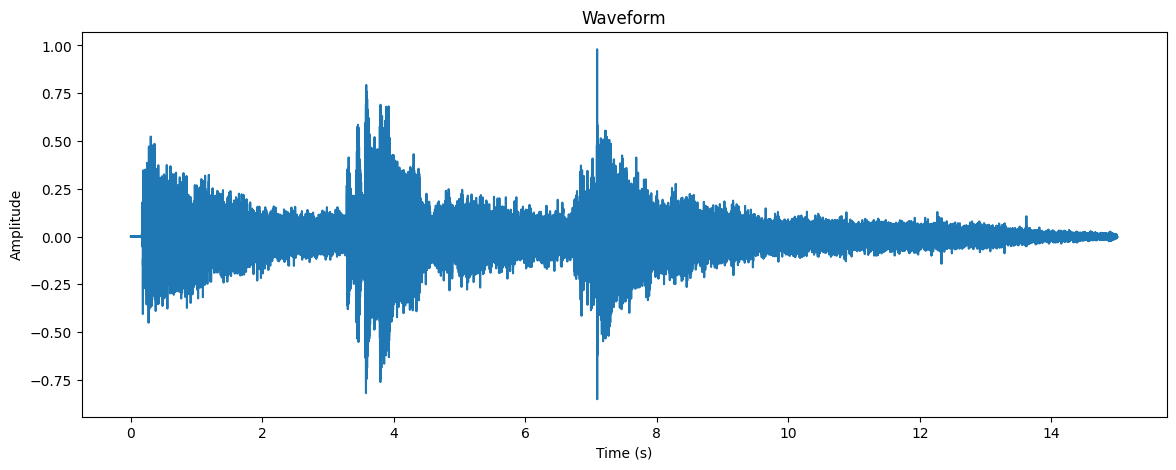

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'sr' is the sample rate
sr = 32000  # Replace with your actual sample rate

# Plot the waveform
plt.figure(figsize=(14, 5))
plt.plot(np.arange(len(audio_values[0][0])) / sr, audio_values[0][0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

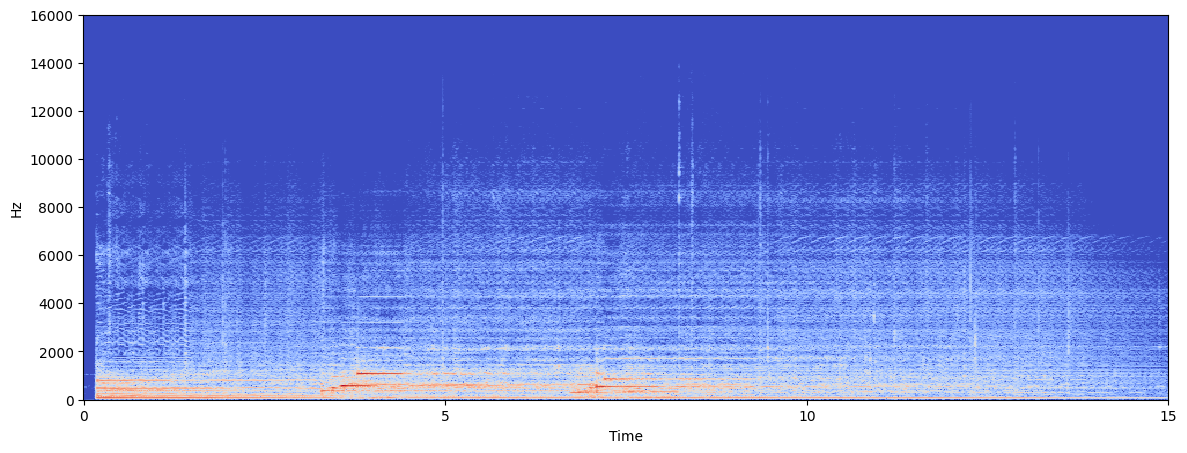

In [67]:
import matplotlib.pyplot as plt

X = librosa.stft(audio_values[0][0])
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=32000, x_axis='time', y_axis='hz')

In [5]:
len(audio_list)

NameError: name 'audio_list' is not defined